# Tutorial

In this tutorial, we briefly introduce the basic usage of **snorer**, from the basic functions related to dark matter (DM) halo, supernova (SN) flux, and boosted dark matter (BDM) flux and event calculations, etc.
This tutorial is not meant for a complete guide for all classses and functions, but a portal to utilize the most important feature for physics calculation.
To have a full description of every functions, we refer the users to API document.
In the following content, all equation numbers refer to [BDM Physics](overview.md#snnu_spectrum) unless specified otherwise.

We begin with importing snorer and other useful packages in this tutorial. We use **ipyparallel** to manifest multiprocessing feature on jupyter for Mac/Windows users. For linux users, they can simply use **multiprocessing**.

In [4]:
# import python packages
import ipyparallel as ipp
import numpy as np

# import snorer
import snorer as sn
print(f'Current version of snorer: {sn.__version__}')

# import only necessary modules from packages
from functools import partial

# import plotting package
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# uncomment this if you have a Hi-DPI monitor and wish to have a better figure resolution
%matplotlib inline
%config InlineBackend.figure_format='retina'

Current version of snorer: 1.0.1


## The SN$\nu$ spectrum

The SN$\nu$ spectrum is shown in Eq. (9)  and the corresponding function in snorer is `sn.sn_nu_spectrum`.
It takes four arguments where the first two `Ev` and `d` are necessary. They indicate the SN$\nu$ energy, in MeV, and the flux at distance $d$ to the SN explosion site.
The last two `d_trunct` and `is_density` are optional. When $d\to 0$, Eq. (9) diverges, one has to set a truncation point. The default is $3.24\times 10^{-15}$ kpc which roughly corresponds to 100 km and is the size of neutrino sphere. `is_density` is to change the output to density unit, see Eq. (12).

/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_18303/647878171.py:16: UserWarning: Log scale: values of z <= 0 have been masked
  contour = ax.contourf(Ev, D, DNvDEv, levels=20, cmap="viridis", norm=norm)


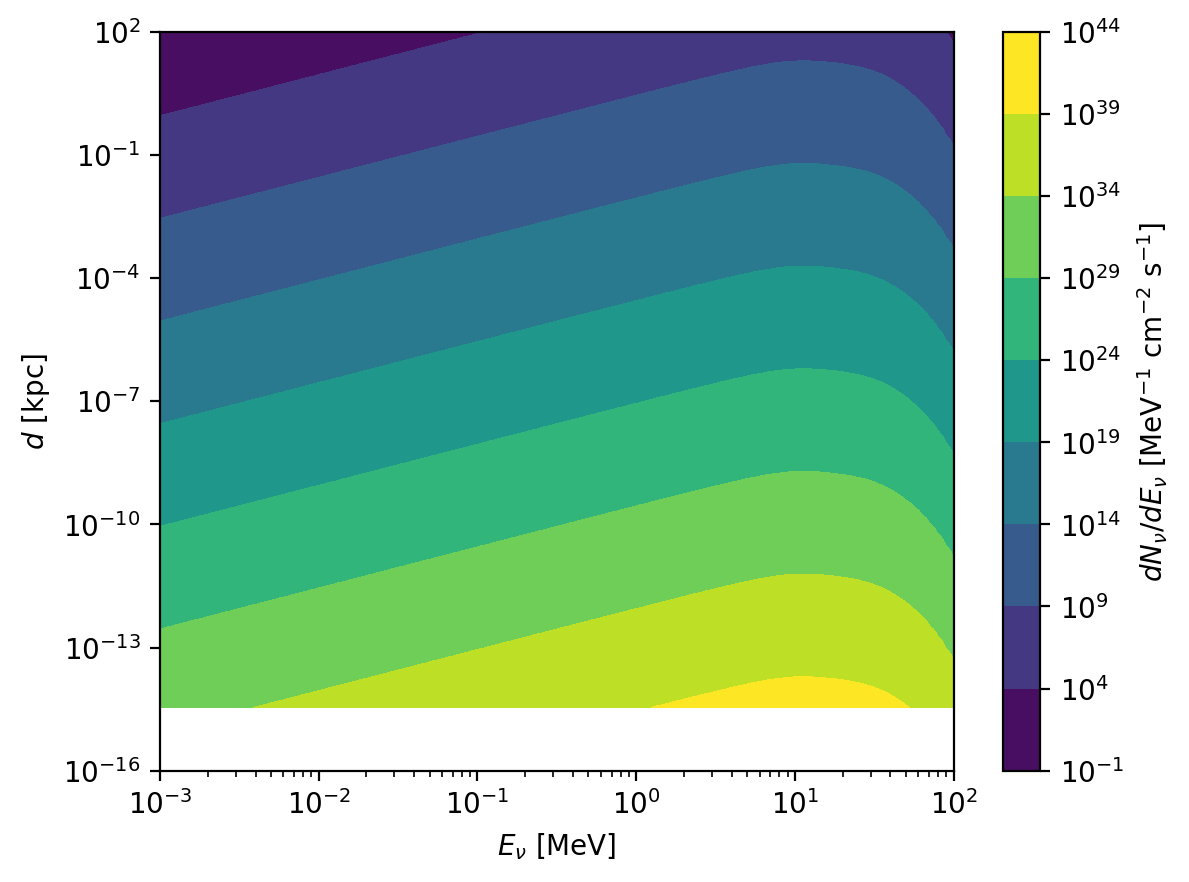

In [6]:
# Neutrino energy
Ev_vals = np.logspace(-3,2,100)
# Distance to the explosion site
d_vals = np.logspace(-16,2,200)

# Setup meshgrid for (Ev,d) plane
Ev,D = np.meshgrid(Ev_vals,d_vals,indexing='ij')
# Evaluate SNv flux
DNvDEv = sn.sn_nu_spectrum(Ev,D)

# Plot
fig, ax = plt.subplots()
# log-scaler color
norm = mcolors.LogNorm(vmin=DNvDEv.min()+1, vmax=DNvDEv.max())
# Contour plot
contour = ax.contourf(Ev, D, DNvDEv, levels=20, cmap="viridis", norm=norm)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$E_\nu$ [MeV]')
ax.set_ylabel(r'$d$ [kpc]')
# Color bar
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label(r"$dN_\nu/dE_\nu$ [MeV$^{-1}$ cm$^{-2}$ s$^{-1}$]")
plt.show()

## The differential DM-$\nu$ cross section

How DM distributes in lab-frame angular direction after boosted by $\nu$ is desecribed by Eq. (2). Given its energy indpendency, we assume the total cross section, after integrating over solid angle, is $\sigma_0$. The differential case is just $\sigma_0 \times g_\chi$.
The corresponding function is `sn.dsigma_xv` and it takes four parameters. The first three are `Ev`, `mx` and `psi`, the incoming neutrino energy (MeV), DM mass (MeV) and lab frame scattering angle (rad). The last one `sigxv0` is $\sigma_0$ and by default is 10<sup>−45</sup> cm<sup>2</sup>. 

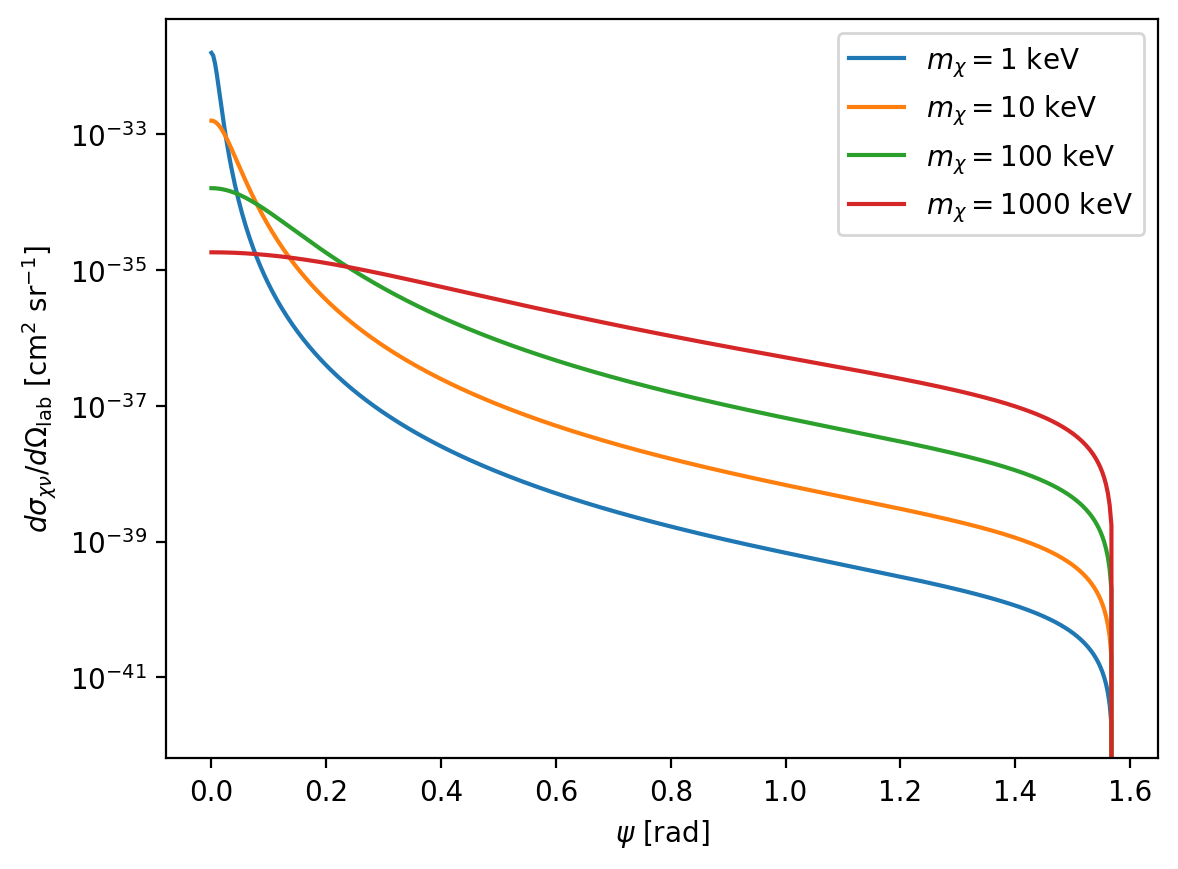

In [112]:
# Neutrino energy, mx values and psi range
Ev = 10
mx_vals = np.logspace(-3,0,4)
sigma0 = 1e-35
psi_vals = np.linspace(0,np.pi/2,500)

for mx in mx_vals:
    # differential cross section
    diff_sigma0 = sn.dsigma_xv(Ev,mx,psi_vals,sigxv0 = sigma0)
    # make plot
    plt.plot(psi_vals,diff_sigma0,label=fr'$m_\chi={1000*mx:.0f}$ keV')
plt.yscale('log')
plt.legend()
plt.xlabel(r'$\psi$ [rad]')
plt.ylabel(r'$d\sigma_{\chi\nu}/d\Omega_{\rm lab}$ [cm$^2$ sr$^{-1}$]')
plt.show()

One can also compare with [`sn.get_gx`](../api/kinematics/get_gx.md) because `sn.dsigma_xv = sigxv0 * sn.get_gx`. Note that the plot in `sn.get_gx` page, we have weighted the result by $d\Omega=2\pi \sin\psi$. It explains the numerics is 0 at $\psi=0$.

## Evaluating SN$\nu$ properties
 
### Flux at Earth

The SN$\nu$ BDM flux at Earth is given by Eq. (18), which has been integrated over the sky that contains non-zero BDM.
The corresponding function is `sn.flux` and takes 8 parameters and `**kwargs`. The first 5 are `t`, `Tx`, `mx`, `Rs` and `beta` that indicate the time of arrival at Earth, relative to SN$\nu$'s arrival at Earth, the BDM kinetic energy (MeV), the BDM mass (MeV), the distance to SN (kpc) and the off-center angle (rad).
The rest 3 optional are `Re = 8.5`, `sigxv0 = 1e-45` and `is_density = False`. `Re` is the distance to galactic center and `is_density` determines whether the halo spike should be included.
For additional keyword arguments, see pages for [`sn.flux`](../api/main/flux.md) and [`sn.params`](../api/params/params.md).

Additionally, BDM flux only lasts unitil $t=t_{\rm van}$, see Eq. (23). To evaluate the time-dependent flux, $t>t_{\rm van}$ is meaningless as the flux is 0.
We can obtain the maximum time to be calculated at first by `sn.get_tvan`. It takes three inputs `Tx`, `mx` and `Rs`.

For example, let's assume there is a SN at $(R_s,\beta)=(9.9\,{\rm kpc},0.33\,{\rm rad})$ and BDM has $(T_\chi,m_\chi)=(10,0.1)$ MeV:

In [8]:
# SN location
Rs, beta = 9.9, 0.33  # kpc, rad

# BDM properties
Tx, mx = 10, 0.1 # MeV

# Get vanishing time
tvan = sn.get_tvan(Tx,mx,Rs)
print(f'Vanishing time is {tvan/sn.constant.year2Seconds:.2f} years.') # convert from seconds to years

Vanishing time is 80.61 years.


For a particular time, say $t=23$ years, one can set

In [10]:
t = 23 * sn.constant.year2Seconds
bdmflux = sn.flux(t,Tx,mx,Rs,beta)
print(f'BDM flux at {t/sn.constant.year2Seconds:.2f} is {bdmflux:.4e} /MeV/cm^2/s.')

BDM flux at 23.00 is 5.5490e-18 /MeV/cm^2/s.


Now we can construct the time-dependent BDM flux, say from $t=0$ to $t=80.61$ years.
In `sn.flux` we use **vegas** to perform the multidimension integral Eq. (18). Hence we use **ipyparallel** to utilize the multiprocessing computing on Mac/Windows jupyter notebook.

In [176]:
# Define a function for multiprocessing flux evaluation by ipyparallel
def get_flux(t):
    from snorer import flux
    Rs, beta = 9.9, 0.33  # kpc, rad
    Tx, mx = 10, 0.1 # MeV
    return flux(t,Tx,mx,Rs,beta)

# Time steps
time_vals = np.logspace(1,np.log10(tvan),50)

# request a cluster
with ipp.Cluster(n = 5) as rc: # 5 cores
    # get a view on the cluster
    view = rc.load_balanced_view()
    # submit the tasks
    asyncresult = view.map_async(get_flux, time_vals)
    # wait interactively for results
    asyncresult.wait_interactive()
    # retrieve actual results
    bdmflux_time = asyncresult.get()

Starting 5 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/5 [00:00<?, ?engine/s]

get_flux:   0%|          | 0/50 [00:00<?, ?tasks/s]

Stopping engine(s): 1741921266
engine set stopped 1741921266: {'engines': {'0': {'exit_code': 0, 'pid': 5889, 'identifier': '0'}, '1': {'exit_code': 0, 'pid': 5890, 'identifier': '1'}, '2': {'exit_code': 0, 'pid': 5891, 'identifier': '2'}, '3': {'exit_code': 0, 'pid': 5892, 'identifier': '3'}, '4': {'exit_code': 0, 'pid': 5893, 'identifier': '4'}}, 'exit_code': 0}
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 5876, 'identifier': 'ipcontroller-1741921265-4v3e-2996'}


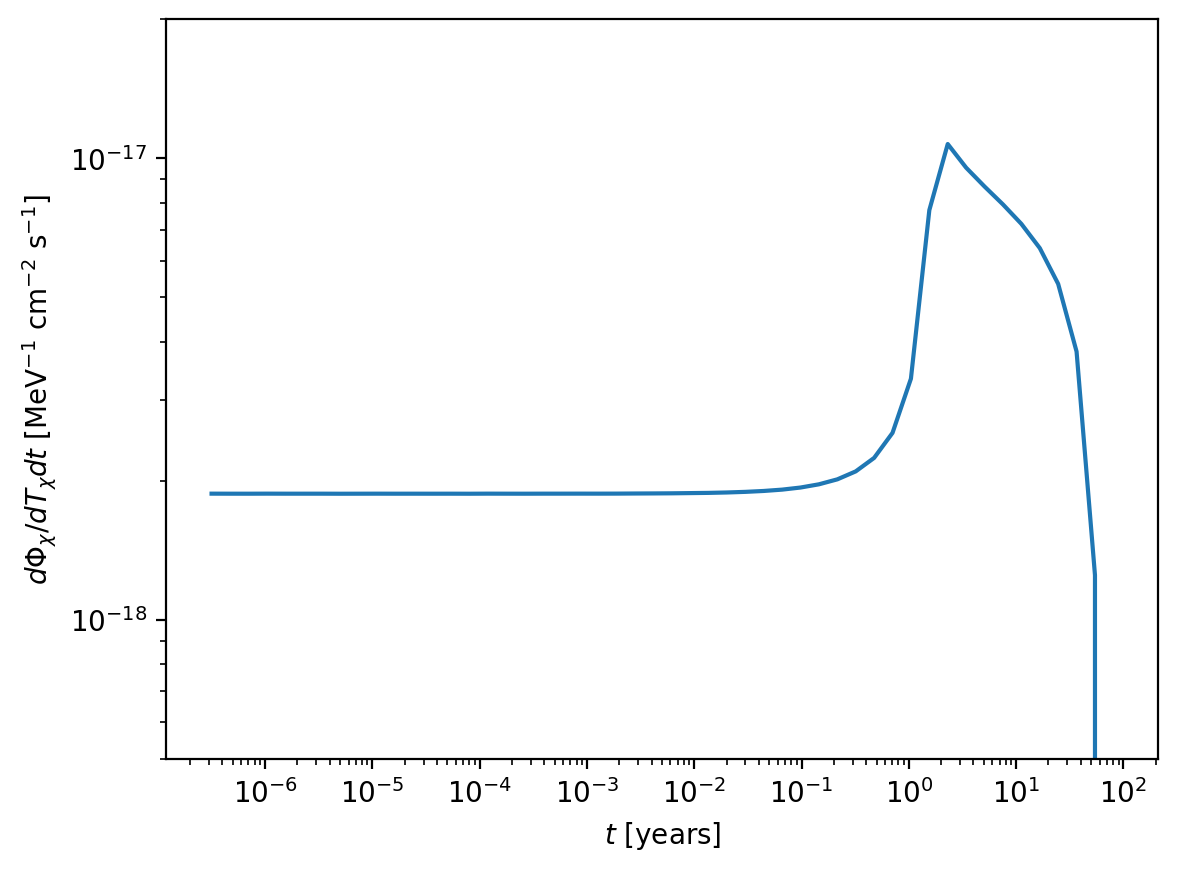

In [192]:
# Plot
plt.plot(time_vals/sn.constant.year2Seconds,bdmflux_time)
plt.xscale('log')
plt.yscale('log')
plt.ylim(5e-19,2e-17)
plt.xlabel(r'$t$ [years]')
plt.ylabel(r'$d\Phi_\chi/dT_\chi dt$ [MeV$^{-1}$ cm$^{-2}$ s$^{-1}$]')
plt.show()

### Event at Earth

We call function `sn.event` to evaluate the BDM event $N_\chi$ at Earth. It's simply

$$
N_\chi =N_e \sigma_{\chi e} \int_{t_{\rm min}}^{t_{\rm max}} dt\int_{T_{\chi,{\rm min}}}^{T_{\chi,{\rm max}}}dT_\chi \frac{d\Phi_\chi}{dT_\chi dt}
$$

It takes 8 inputs and `**kwargs`. The first three `mx`, `Rs` and `beta` are necessary.
The last five `Re`, `Tx_range`, `t_range`, `sigxv0` and `is_spike` are optional. By default `Tx_range = [5,30]` is the $T_\chi$-integration range (MeV) and `t_range = [10,1.1045e+09]` is the time-integration range (seconds). The default $t_{\rm max}$ approximates 35 years. Note that the function will automatically truncate $t_{\rm max}$ at $t_{\rm van}$ if the user-input $t_{\rm max}$ is greater than $t_{\rm van}$.

Note that `sn.event` is normalized to $N_e = 1$, the electron number, and $\sigma_{\chi e}=1$ cm<sup>2</sup>, the DM-electron cross section.
One can easily scale the result to a detector with arbitrary number of $N_e$ and  $\sigma_{\chi e}=1$.

In [302]:
# Define a function for multiprocessing event evaluation by ipyparallel
def get_event(mx):
    from snorer import event
    Rs, beta = 8.5, 0.0  # kpc, rad
    return event(mx,Rs,beta,r_cut=1e-5,neval=30000)  # increasing the evaluation number in each MCMC chain in vegas

# DM mass to be evaluated
mx_vals = np.logspace(-6,2,35)

# request a cluster
with ipp.Cluster(n = 5) as rc: # 5 cores
    # get a view on the cluster
    view = rc.load_balanced_view()
    # submit the tasks
    asyncresult = view.map_async(get_event, mx_vals)
    # wait interactively for results
    asyncresult.wait_interactive()
    # retrieve actual results
    bdmevent_mx = asyncresult.get()

Starting 5 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/5 [00:00<?, ?engine/s]

get_event:   0%|          | 0/35 [00:00<?, ?tasks/s]

engine set stopped 1741928354: {'engines': {'0': {'exit_code': 0, 'pid': 9398, 'identifier': '0'}, '1': {'exit_code': 0, 'pid': 9399, 'identifier': '1'}, '2': {'exit_code': 0, 'pid': 9400, 'identifier': '2'}, '4': {'exit_code': 0, 'pid': 9402, 'identifier': '4'}, '3': {'exit_code': 0, 'pid': 9401, 'identifier': '3'}}, 'exit_code': 0}
Stopping engine(s): 1741928391
engine set stopped 1741928391: {'engines': {'0': {'exit_code': 0, 'pid': 9444, 'identifier': '0'}, '1': {'exit_code': 0, 'pid': 9445, 'identifier': '1'}, '2': {'exit_code': 0, 'pid': 9446, 'identifier': '2'}, '3': {'exit_code': 0, 'pid': 9447, 'identifier': '3'}, '4': {'exit_code': 0, 'pid': 9448, 'identifier': '4'}}, 'exit_code': 0}
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 9432, 'identifier': 'ipcontroller-1741928390-sv9q-2996'}


Assume $N_e=3\times 10^{33}$ and $\sigma_{\chi e}=10^{-35}$ cm<sup>2</sup>:

In [18]:
Ne = 1e33
sigxe = 1e-35
bdmevent_mx = np.array(bdmevent_mx) * Ne * sigxe

# Plot
plt.scatter(mx_vals,bdmevent_mx)
plt.xscale('log')
plt.yscale('log')
#plt.ylim(5e-19,2e-17)
plt.xlabel(r'$m_\chi$ [MeV]')
plt.ylabel(r'$N_\chi$')
plt.show()

### More about `**kwargs` in `sn.flux` and `sn.event`

We elaborate the optional parameters contained in `**kwargs` for both `sn.flux` and `sn.event`. Practically, they determine the DM halo shape (`sn.params.halo` and `sn.params.spike`) and control **vegas** algortihm (`sn.params.vegas`). See its [API page](../api/params/params.md) for detail.

For halo related `**kwargs`, if sets `is_spike = False`, then only three are avalaible:

1. `rhos`: Characteristic denisty, MeV cm<sup>-3</sup>.
2.  `rs`: Characteristic length, kpc.
3.  `n`: Halo profile slope.

If `is_spike = True`, then there are five additional `**kwargs` will be activated:

4. `mBH`: Supermassive black hole (SMBH) mass, $M_\odot$.
5. `tBH`: SMBH age, years.
6. `rh`: SMBH influence radius, kpc.
7. `alpha`: Spike slope, string type, only two options: `'3/2'` and `'7/3'`.
8. `sigv`: DM annihilation cross section in the unit of 10<sup>-26</sup> cm<sup>3</sup> s<sup>-1</sup>. For example, if we wish to have $\langle \sigma v\rangle = 3\times 10^{-26}$ cm<sup>3</sup> s<sup>-1</sup>, we simply set `sigv = 3`.

If one sets `is_spike = False` and typing any of the above `**kwargs` for spiky halo, ValueError will appear.

Now if we want to evaluate a galaxy similar to our Milky Way but $\rho_s=100$ and $n=3.3$. Also we wish to have spike feature, such as SMBH mass is $10^7~M_\odot$ and strong annihilation such that $\langle \sigma v\rangle = 13\times 10^{-26}$. We can then evaluate

In [12]:
# Halo setup
rhos, n = 100, 3.3
mBH, sigv = 1e7, 13

# SN location
Rs, beta = 9.9, 0.33  # kpc, rad

# BDM properties
Tx, mx = 10, 0.1 # MeV

# Get vanishing time
tvan = sn.get_tvan(Tx,mx,Rs)

# Flux
t = 15*sn.constant.year2Seconds 
bdmflux_customized = sn.flux(t,Tx,mx,Rs,beta,is_spike = True,mBH = mBH, sigv = sigv, neval = 15000)
print(bdmflux_customized)

6.612073937090113e-18


## Coordinate transform and SN in arbitrary distant galaxy

**snorer** also provides functions for converting galactic and equatorial coordinates into off-center angle $\beta$, see [Coordinate Transoformation](../api/utils/coord_transf.md) for discussion.
This aids us to compute those SNe documented in [SRcat](http://snrcat.physics.umanitoba.ca/).

For example, the [Crab Neubla](http://snrcat.physics.umanitoba.ca/SNRrecord.php?id=G184.6m05.8) has $(\alpha,\delta)= (05{\rm h}34{\rm m}31{\rm s}, 22{\rm d}01{\rm m}00{\rm s})$ in equatorial coordinate based on ICRS J2000.0 frame. We can obtain $\beta$ by `sn.equatorial_to_beta`. This function takes three inputs and the first two are `ra` and `dec` in string type which correspond to $\alpha$ and $\delta$ of the SN to be investigated.
The third one `GC_coord` is optional. Default `None` will automatically refer to Milky Way center. If you have your own prefer galaxy to be studied, please specifiy as `GC = [gc_ra,gc_dec]` where `gc_ra` and `gc_dec` are the equatorial coordinate of the galactic center.

Additionally, `sn.equatorial_to_beta` will output a tuple contains three values $(\beta,\ell,b)$ where the last two indicate the galactic coordinate $\ell$ and $b$ of SN.

In [350]:
# Coordinate
crab_ra, crab_dec = '05h34m31s', '22d01m004'
crab_beta,_,_ = sn.equatorial_to_beta(crab_ra,crab_dec)
print(f'Off-center angle of Crab Neubla is {crab_beta:.3e} rad.')

Off-center angle of Crab Neubla is 3.013e+00 rad.


Now we show a case where SN is not in the Milky Way, the SN1987a, which located in Large Magellanic Cloud. There locations are given in

In [354]:
# Print LMC coordinate: ra,dec,dist
print(sn.constant.LMC_coord)

# Print SN1987a coordinate: ra,dec,dist
print(sn.constant.SN1987a_coord)

['05h23m34.5264s', '-69d45m22.053s', 49.97]
['05h35m27.8733s', '-69d16m10.478s', 51.4]


Hence to get $\beta$, we do

In [14]:
SN1987a_ra,SN1987a_dec,Rs = sn.constant.SN1987a_coord
LMC_ra,LMC_dec,Rg = sn.constant.LMC_coord
sn1987a_beta,_,_ = sn.equatorial_to_beta(SN1987a_ra,SN1987a_dec,GC_coord=[LMC_ra,LMC_dec])

To evaluate event, we still use `sn.event` but have to specify `Re` by `Rg` because the default `Re = 8.5` implies the distance between Earth and Milky Way center.

In [20]:
mx = 0.5
beta = 0.0  # kpc, rad
SN1987a_event = sn.event(mx,Rs,beta,Re=Rg,r_cut=1e-5,neval=30000)
SN1987a_event *= (Ne * sigxe) # Assuming Ne and sigma_xe follow previously
print(f'BDM event from SN1987a in LMC is {SN1987a_event:.3e}.')

BDM event from SN1987a in LMC is 8.468e-13.
